## Context

We address the following RQ: 

Are SMALL programs with divergent execution more understandable than larger ones?

We inspect some programs which lead to divergent behaviour in:
- experiment_v07: big programs (# bits: 2 .. 20, # ops 30 .. 200)
- experiment_v08: small programs (# bits: 2 .. 15, # ops 5 .. 25)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../lib")
import seaborn as sns
import matplotlib.pyplot as plt
from utils import iterate_over
from utils import load_config_and_check
from inspector import Inspector
from analyser import Explorer
import os

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#EXPERIMENT_VERSION = "08"
#config = load_config_and_check(f"../config/experiment_v{EXPERIMENT_VERSION}.yaml")
#comparison_names = [e["name"] for e in config['comparisons']]
#print(f"Avilable comparisons: {comparison_names}")
#COMPARISON_NAME = "cross_platform"
#FOLDER_EXECUTIONS = os.path.join(config["experiment_folder"], COMPARISON_NAME, "executions")

In [11]:
def get_df_and_inspector(experiment_version, dataset_filename="40k_comparisons.csv", comparison_name="cross_platform"):
    """Get the dataset and initialize the inspector to see execution results.
    
    Note that the dataset must be precomputed with another notebook and it 
    is expected to be in the prediction folder in csv format.
    """
    
    config = load_config_and_check(
        f"../config/experiment_v{experiment_version}.yaml")
    
    comparison_names = [e["name"] for e in config['comparisons']]
    print(f"Avilable comparisons: {comparison_names}")
    folder_executions = os.path.join(
        config["experiment_folder"], comparison_name, "executions")
    sherlock = Inspector(folder_executions=folder_executions)
    
    folder_program_info = os.path.join(
        config["experiment_folder"], comparison_name, "original_programs")
    all_program_info = list(
        iterate_over(folder_program_info, ".json", parse_json=True))
    all_program_info = [e[1] for e in all_program_info]
    df_program_info = pd.DataFrame.from_records(all_program_info)
    df_program_info.rename(columns={"circuit_id": "program_id"}, inplace=True)
    # print(df_program_info.info())
    
    
    path_csv = f"../data/experiment_v{experiment_version}/cross_platform/predictions/{dataset_filename}"
    df_results = pd.read_csv(path_csv, index_col=0)
    df_results["program_id"] = df_results["program_id"].astype(str)
    # print(df_results.info())
    df_results = pd.merge(df_results, df_program_info, on="program_id")
    
    return df_results, sherlock
    
    
df_big, sherlock_big = get_df_and_inspector(experiment_version="07")
df_small, sherlock_small = get_df_and_inspector(experiment_version="08")

Avilable comparisons: ['cross_platform']
Avilable comparisons: ['cross_platform']


## Most divergent programs

BIG Dataset
Average p_values in the top 10 is 0.00195454462506758
SMALL Dataset
Average p_values in the top 10 is 0.009586288944560092


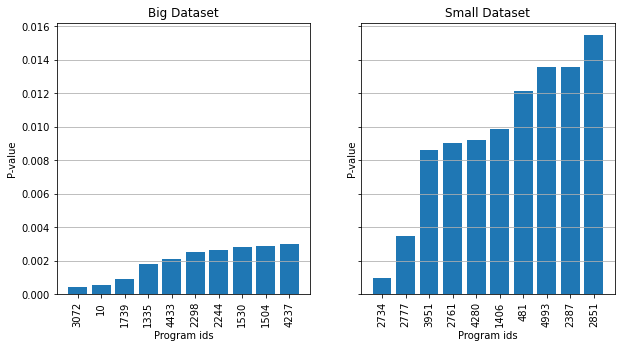

In [12]:
TOP_K = 10

def get_top_k(df, top_k=10, ax=None, title=""):
    df_top_k = df.sort_values(by="p_value_40k").head(TOP_K)
    top_k_pvalues = df_top_k["p_value_40k"]
    top_k_program_ids = df_top_k["program_id"]
    print(f"Average p_values in the top {top_k} is {np.mean(top_k_pvalues)}")
    ax.bar(range(len(top_k_program_ids)), top_k_pvalues)
    ax.set_title(title)
    ax.set_xticks(ticks=range(len(top_k_program_ids)))
    ax.set_xticklabels(labels=top_k_program_ids, rotation=90)
    ax.set_ylabel("P-value")
    ax.set_xlabel("Program ids")
    ax.grid(axis="y")
    return df_top_k


fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
print("BIG Dataset")
df_divergent_big = get_top_k(df_big, top_k=TOP_K, ax=axes[0], title="Big Dataset")
print("SMALL Dataset")
df_divergent_small = get_top_k(df_small, top_k=TOP_K, ax=axes[1], title="Small Dataset")

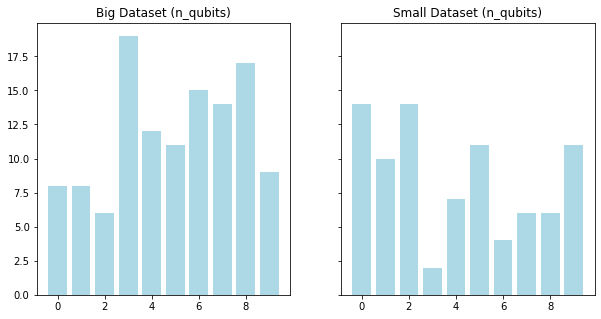

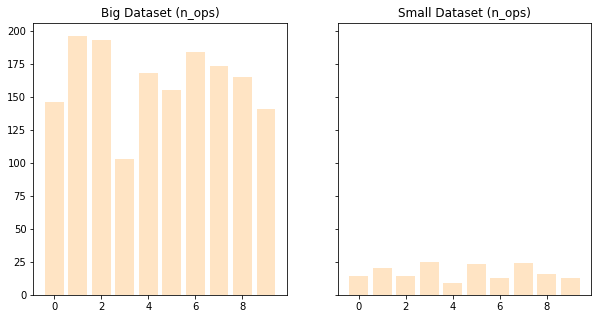

In [13]:
def compare_on(df_big, df_small, column_name, color):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    ax_big = axes[0]
    ax_small = axes[1]

    ax_big.bar(range(len(df_big)), df_big[column_name], color=color)
    ax_big.set_title(f"Big Dataset ({column_name})")

    ax_small.bar(range(len(df_small)), df_small[column_name], color=color)
    ax_small.set_title(f"Small Dataset ({column_name})")
    
compare_on(df_divergent_big, df_divergent_small, column_name="n_qubits", color='lightblue')
compare_on(df_divergent_big, df_divergent_small, column_name="n_ops", color='bisque')

<AxesSubplot:xlabel='p_value_40k', ylabel='program_size'>

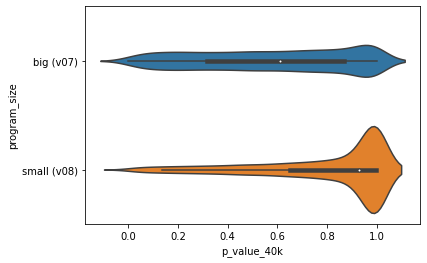

In [14]:
df_big["program_size"] = 'big (v07)'
df_small["program_size"] = 'small (v08)'
df_all = pd.concat([df_big, df_small], axis=0)
sns.violinplot(
    data=df_all,
    y="program_size",
    x="p_value_40k"
)

Conslusion: larger programs tend to have a larger p-value.

## Inspect the top 10

In [15]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   program_id                   5000 non-null   object 
 1   p_value_40k                  5000 non-null   float64
 2   stat_40k                     5000 non-null   float64
 3   n_qubits                     5000 non-null   int64  
 4   n_ops                        5000 non-null   int64  
 5   gate_set                     5000 non-null   object 
 6   strategy_program_generation  5000 non-null   object 
 7   benchmark_name               5000 non-null   object 
 8   program_size                 5000 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 390.6+ KB


SMALL: 2734. n_qubits: 14. p_value: 0.000989979284444. n_ops: 14


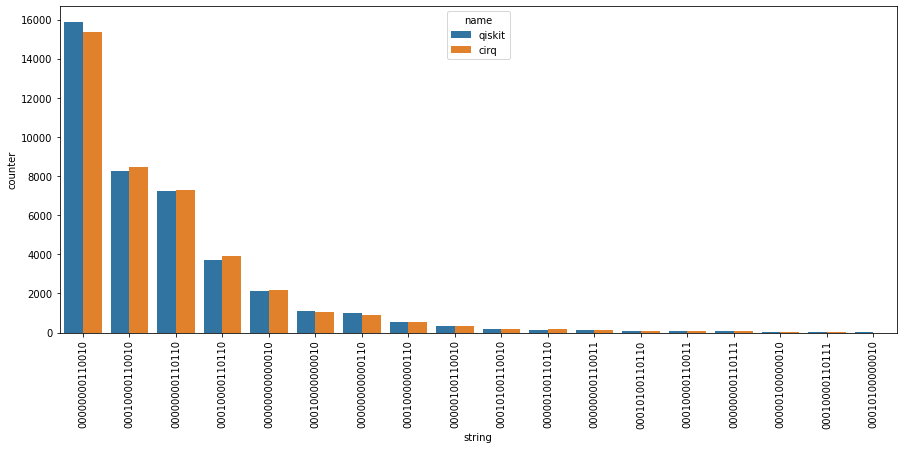

SMALL: 2777. n_qubits: 10. p_value: 0.003463756792196. n_ops: 20


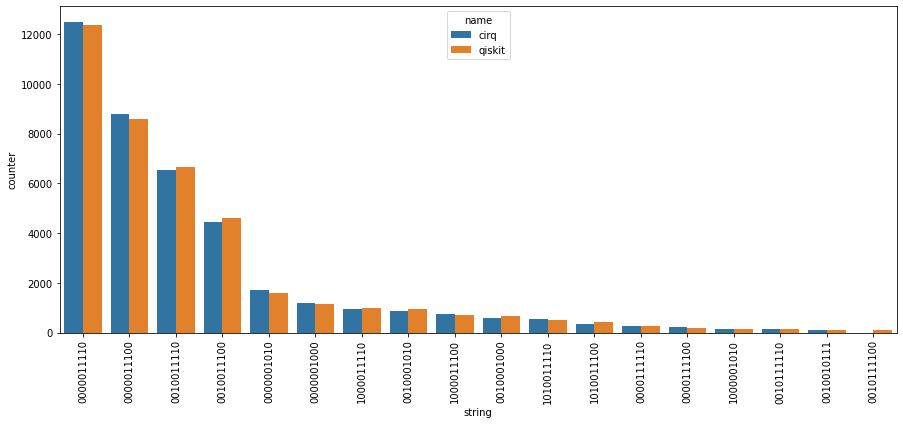

SMALL: 3951. n_qubits: 14. p_value: 0.0086197484006828. n_ops: 14


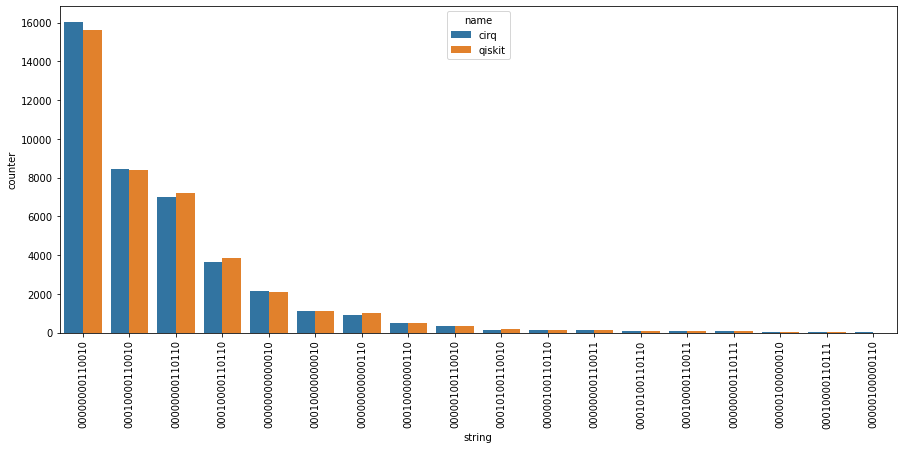

SMALL: 2761. n_qubits: 2. p_value: 0.0090257964572239. n_ops: 25


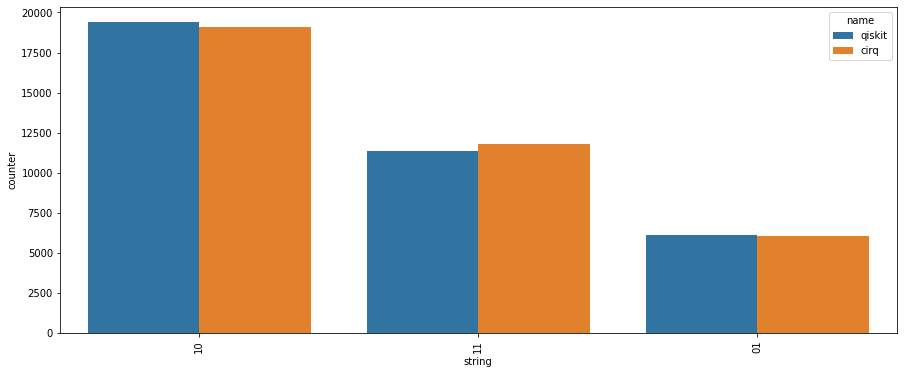

SMALL: 4280. n_qubits: 7. p_value: 0.0092352614420911. n_ops: 9


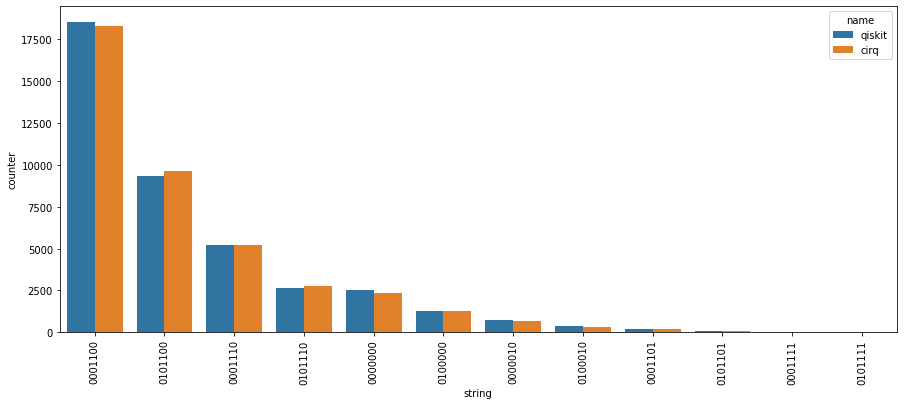

SMALL: 1406. n_qubits: 11. p_value: 0.0098903785869479. n_ops: 23


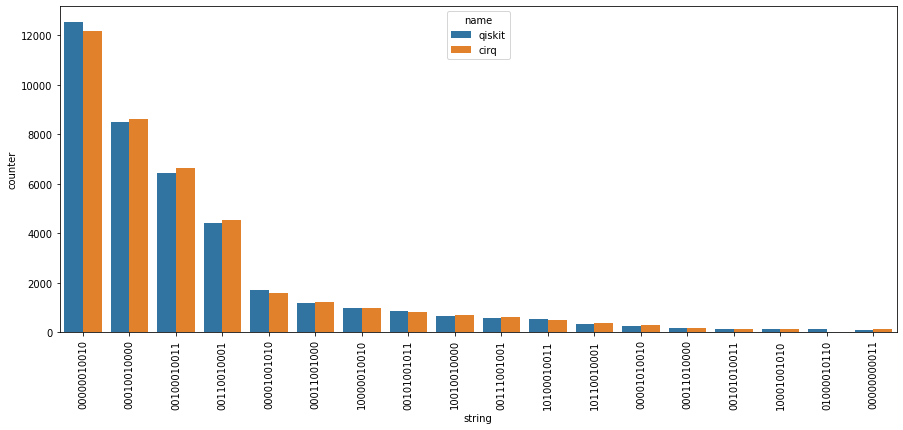

SMALL: 481. n_qubits: 4. p_value: 0.0121159866020008. n_ops: 13


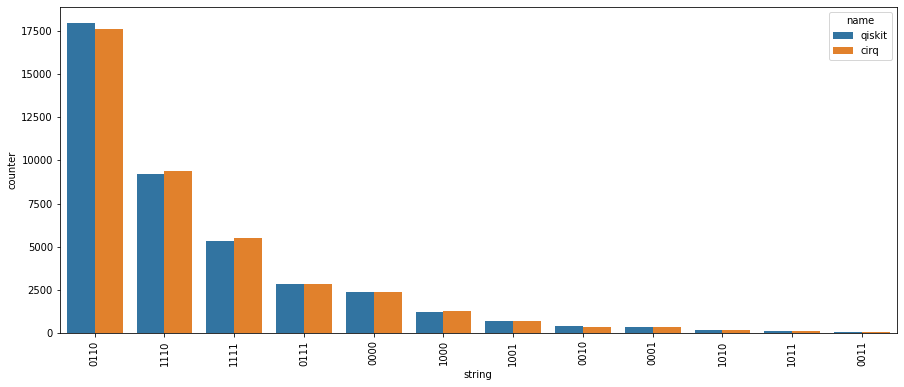

SMALL: 4993. n_qubits: 6. p_value: 0.013538993908194. n_ops: 24


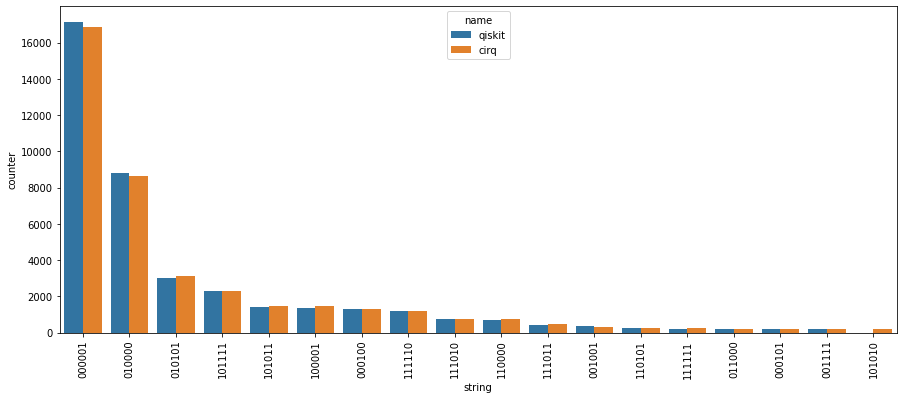

SMALL: 2387. n_qubits: 6. p_value: 0.013538993908194. n_ops: 16


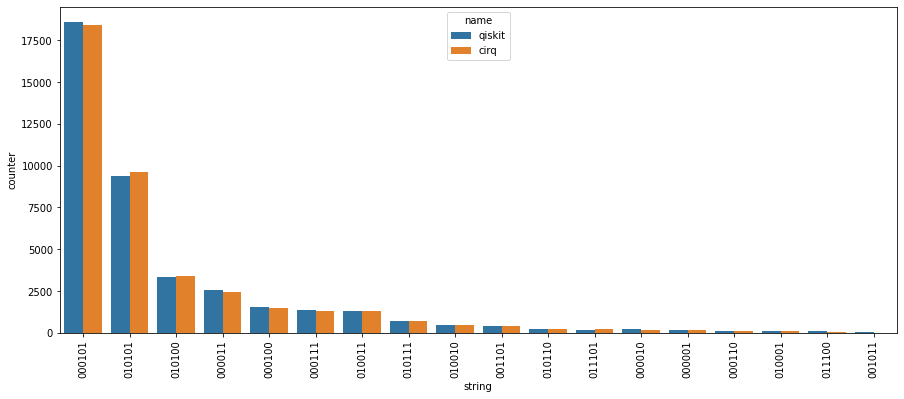

SMALL: 2851. n_qubits: 11. p_value: 0.0154439940636264. n_ops: 13


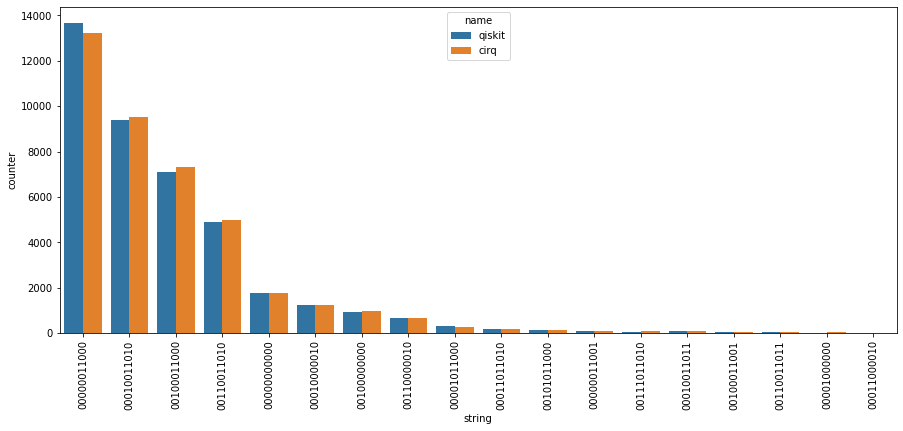

In [16]:
for i, row in df_divergent_small.iterrows():
    program_id = row["program_id"]
    n_bits = row["n_qubits"]
    n_ops = row["n_ops"]
    p_value = row["p_value_40k"]
    print(f"SMALL: {program_id}. n_qubits: {n_bits}. p_value: {p_value}. n_ops: {n_ops}")
    sherlock_small.inspect(df=df_small, divergent_id=int(program_id), colname_pvalue="p_value_40k")
    sherlock_small.plot_histogram_together(top_perc=.75, max_solutions=35, figsize=(15, 6))

BIG: 3072. n_qubits: 8. p_value: 0.0004153087691487


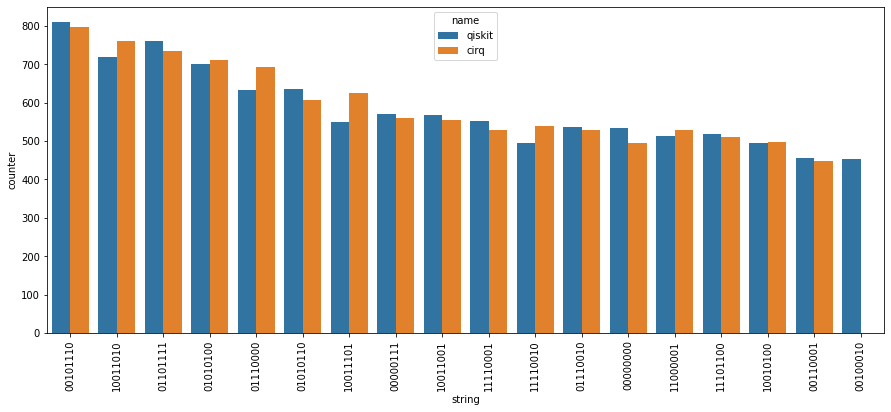

BIG: 10. n_qubits: 8. p_value: 0.0005370276558776


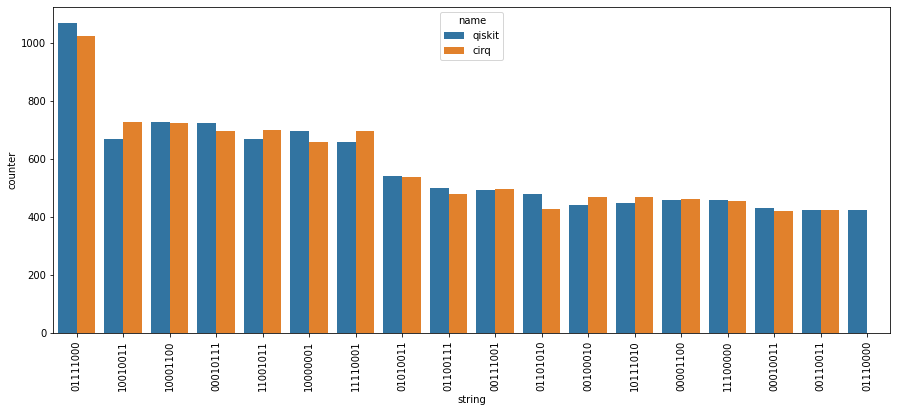

BIG: 1739. n_qubits: 6. p_value: 0.0008873469020073


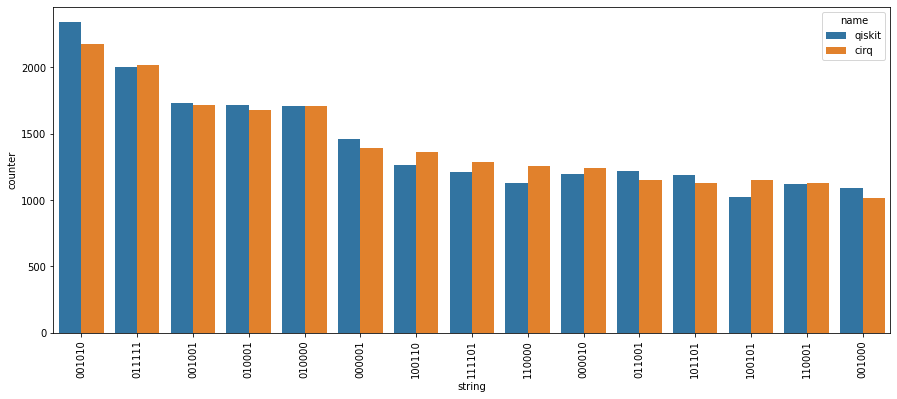

BIG: 1335. n_qubits: 19. p_value: 0.0017823358003535


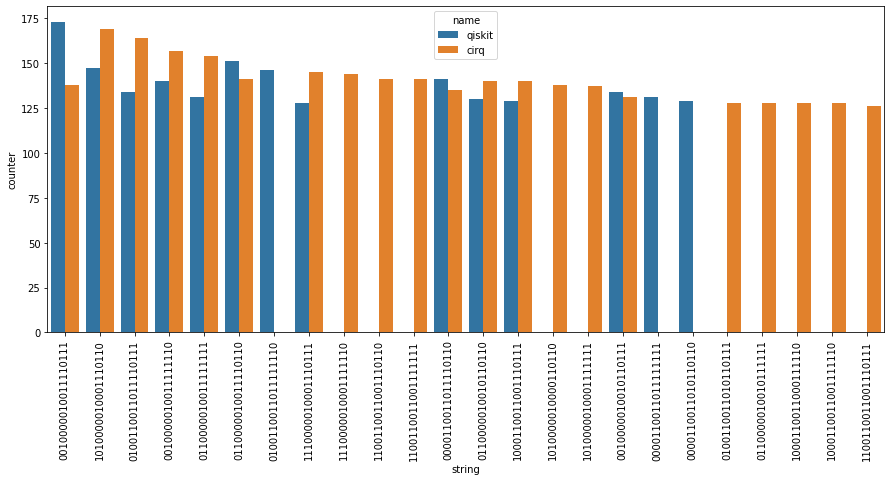

BIG: 4433. n_qubits: 12. p_value: 0.0020837826543044


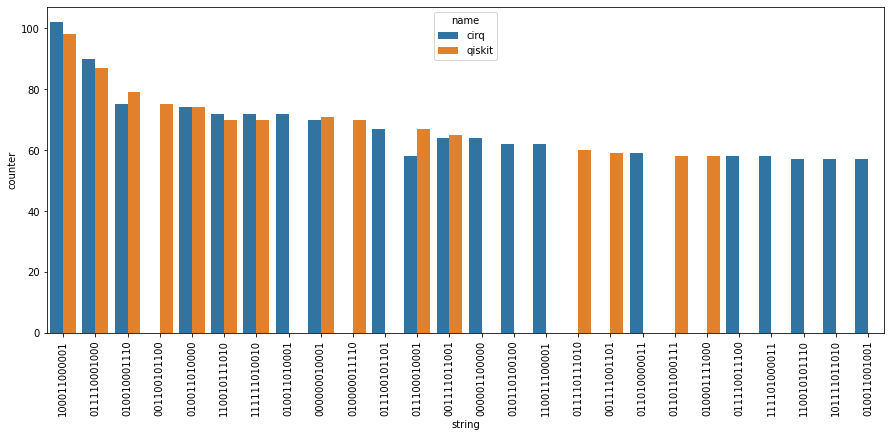

BIG: 2298. n_qubits: 11. p_value: 0.0024949435272746


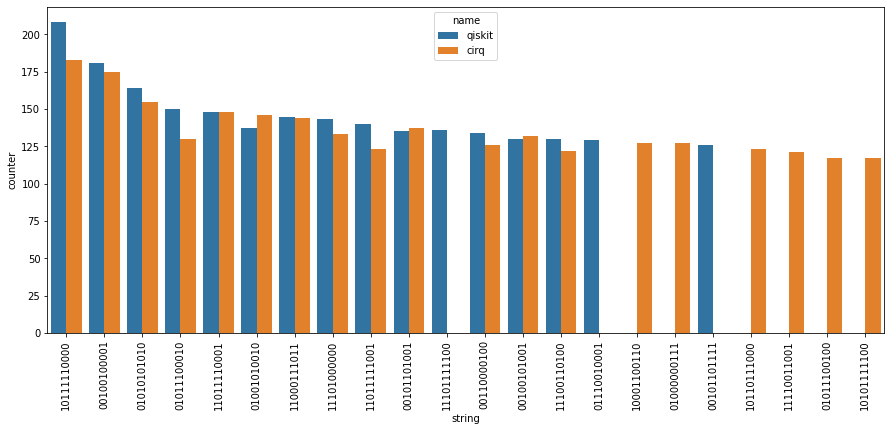

BIG: 2244. n_qubits: 15. p_value: 0.0026255183442873


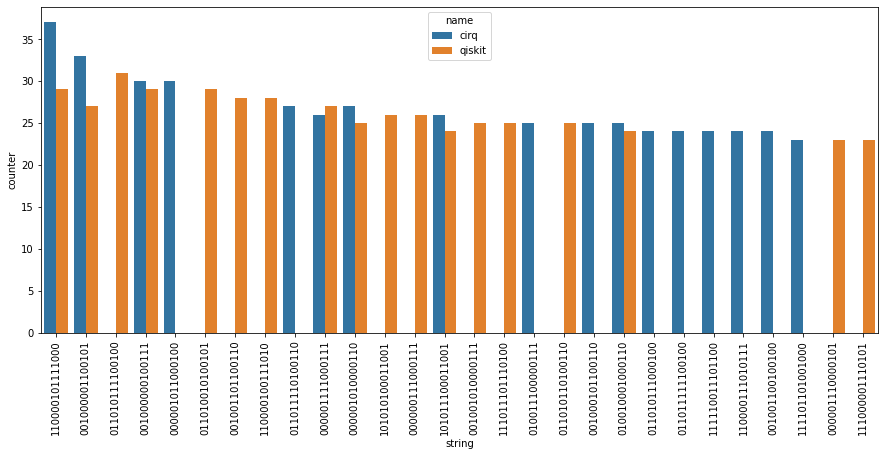

BIG: 1530. n_qubits: 14. p_value: 0.0028332668922736


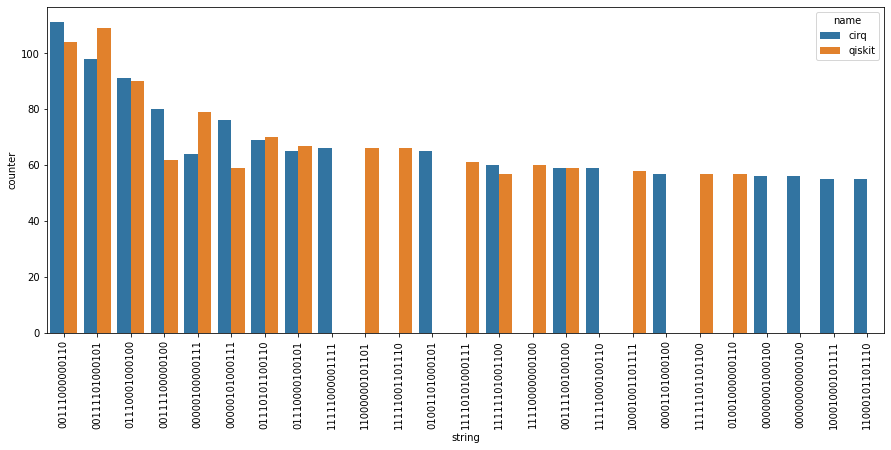

BIG: 1504. n_qubits: 17. p_value: 0.0029058233538024


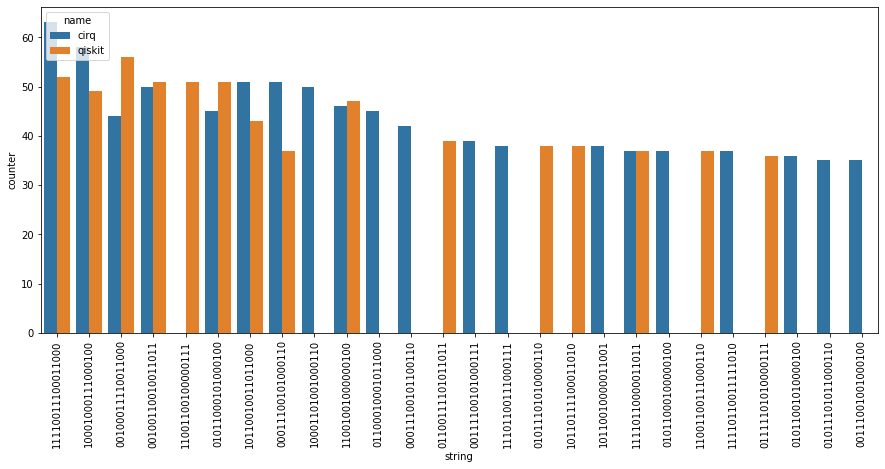

BIG: 4237. n_qubits: 9. p_value: 0.0029800923513464


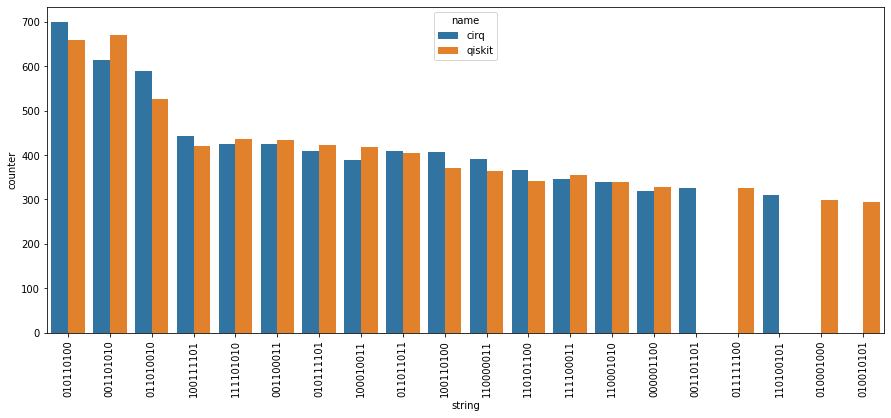

In [17]:
for i, row in df_divergent_big.iterrows():
    program_id = row["program_id"]
    n_bits = row["n_qubits"]
    p_value = row["p_value_40k"]
    print(f"BIG: {program_id}. n_qubits: {n_bits}. p_value: {p_value}")
    #show_perc = (1/(2*n_bits)) if n_bits > 10 else 1
    sherlock_big.inspect(df=df_big, divergent_id=int(program_id), colname_pvalue="p_value_40k")
    sherlock_big.plot_histogram_together(top_perc=.25, max_solutions=35, figsize=(15, 6))

Conclusion: program id 4280 of the small dataset is a good candidate for further checks.

## Rerun and check p-value

In [18]:
from simulators import QconvertCircuit
from detectors import KS_Detector
from detectors import Energy_Detector

In [22]:
possile_bugs_in_small_dataset = list(df_divergent_small["program_id"])
possile_bugs_in_small_dataset

['2734', '2777', '3951', '2761', '4280', '1406', '481', '4993', '2387', '2851']

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

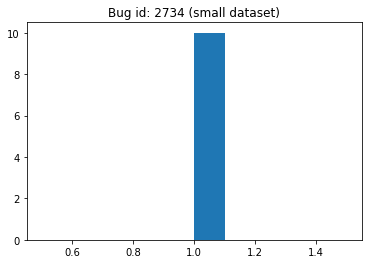

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

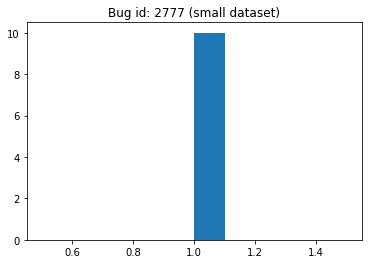

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Error: output file "./qconvert_tmp_cache/b9a384b75064178a851512601704ee5da744780b2f584cad78055b98.py" already exists.
Use -w switch to overwrite.
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	So

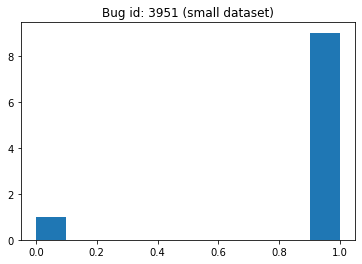

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

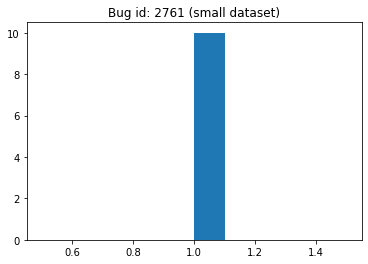

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Error: output file "./qconvert_tmp_cache/a75d63e53b4172d0bf2d017a4f3ad350e073146a5c073cf7c05c7764.py" already exists.
Use -w switch to overwrite.
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	So

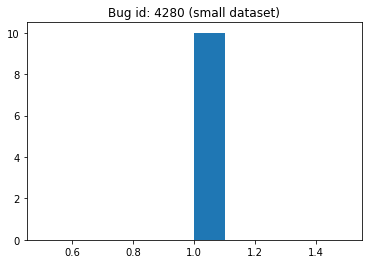

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

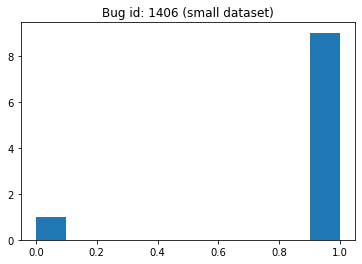

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

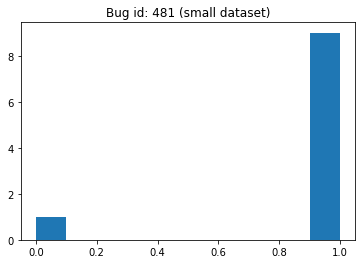

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

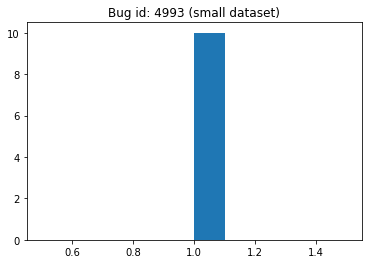

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

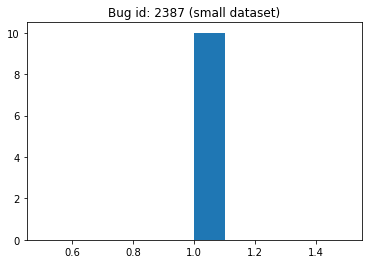

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

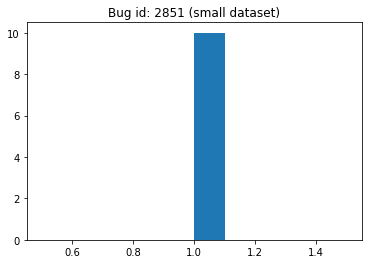

In [23]:
#ID_UNDER_INSPECTION = 4280
detector = Energy_Detector()
N_ROUND = 10

for id_under_inspection in possile_bugs_in_small_dataset:
    qasm_path = f"../data/experiment_v08/cross_platform/original_programs/{id_under_inspection}.qasm"
    qasm_content = open(qasm_path, 'r').read()
    simulator_cirq = QconvertCircuit(target_platform='cirq', repetitions=8192)
    simulator_cirq.from_qasm(qasm_content)
    simulator_qiskit = QconvertCircuit(target_platform='qiskit', repetitions=8192)
    simulator_qiskit.from_qasm(qasm_content)

    executions_cirq = []
    executions_qiskit= []
    p_values = []
    stats = []
    
    for i in range(N_ROUND):
        print(f"Iteration: {i}")
        simulator_cirq.execute()
        res_cirq = simulator_cirq.get_result()

        simulator_qiskit.execute()
        res_qiskit = simulator_qiskit.get_result()

        executions_cirq.append(res_cirq)
        executions_qiskit.append(res_qiskit)

        stat, p_value = detector.check(res_cirq, res_qiskit)
        p_values.append(p_value)
        stats.append(stat)
    
    plt.hist(p_values)
    plt.title(f"Bug id: {id_under_inspection} (small dataset)")
    plt.show()

In [23]:
for res_cirq, res_qiskit in zip(executions_cirq, executions_qiskit):
    stat, p_value = detector.check(res_cirq, res_qiskit)
    p_values.append(p_value)
    stats.append(stat)

(array([ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

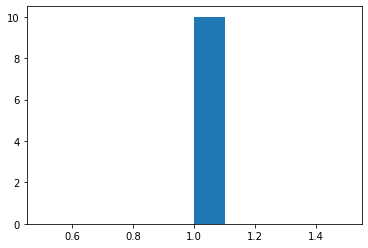

In [24]:
plt.hist(p_values)

Conclusion: this program is not anomalous according to the Energy test.

## Miscellanea

In [6]:
sherlock = Inspector(folder_executions=FOLDER_EXECUTIONS)

In [22]:
sherlock.inspect(df=df_results, divergent_id=2734, colname_pvalue="p_value_40k")

In [23]:
sherlock.p1_results

{'00000000000011': 17,
 '00010000110010': 8240,
 '00010100110000': 1,
 '00010000000110': 520,
 '00000000110100': 3,
 '00000000000111': 10,
 '00000000110011': 127,
 '00000100000010': 43,
 '00000000000010': 2136,
 '00010000000010': 1099,
 '00000100000110': 25,
 '00010000000011': 11,
 '00010000110110': 3695,
 '00000100110011': 2,
 '00010100000110': 10,
 '00010000000111': 7,
 '00010100000010': 31,
 '00010100110010': 172,
 '00000000110010': 15878,
 '00000000110111': 60,
 '00010000110111': 38,
 '00000100110010': 329,
 '00010100110011': 2,
 '00010000110011': 63,
 '00000100110110': 146,
 '00010100110110': 80,
 '00000000110000': 4,
 '00010100110111': 2,
 '00000000000110': 987,
 '00000000110110': 7221,
 '00010000110100': 1}

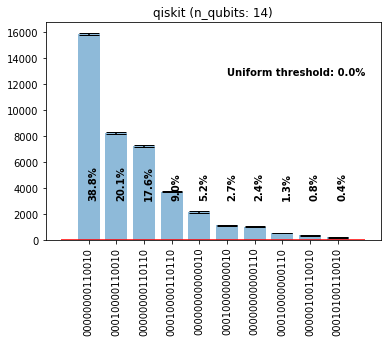

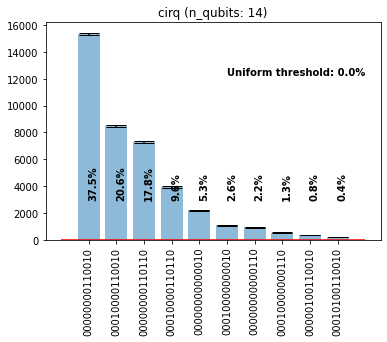

In [24]:
sherlock.plot_execution_top_k()

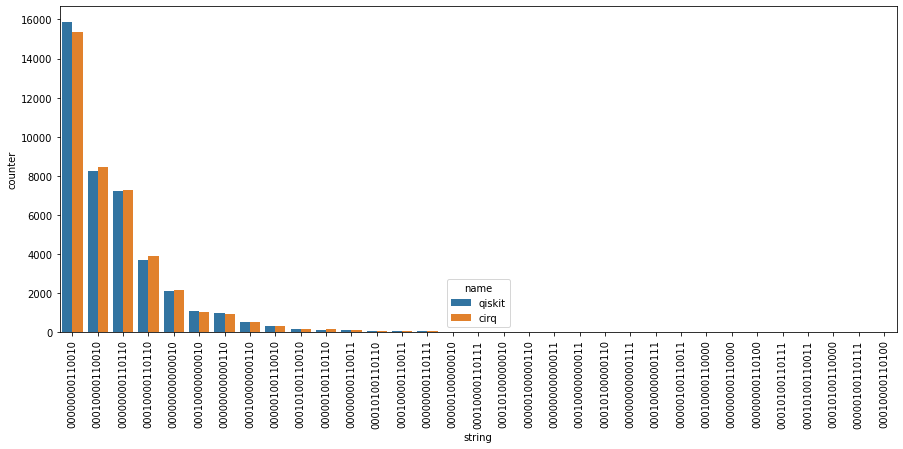

In [25]:
sherlock.plot_histogram_together(top_perc=1, figsize=(15, 6))

In [26]:
sherlock.p_value

0.000989979284444

<Figure size 1080x432 with 0 Axes>

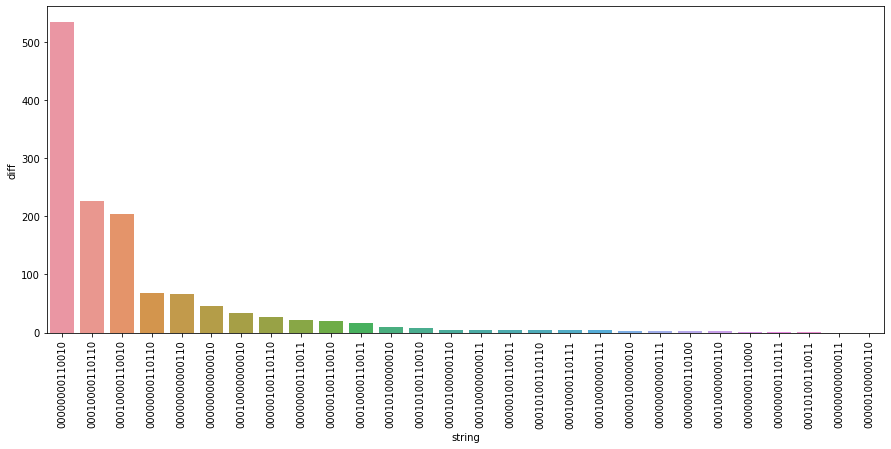

In [27]:
sherlock.plot_most_divergent_output(top_perc=1, figsize=(15, 6))